In [9]:
# Link: https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1 (A very simple autoencoder)
# !pip install torch torchvision


In [12]:
import torch
print("Cuda device name: %s" % str(torch.cuda.get_device_name(device=None)))
print("Device ability: %s" % str(torch.cuda.get_device_capability(device=None)))


Cuda device name: Tesla P100-PCIE-16GB
Device ability: (6, 0)


In [8]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:         7224224 kB
MemAvailable:   10953328 kB
Buffers:           78556 kB
Cached:          3288904 kB
SwapCached:            0 kB
Active:          2104744 kB
Inactive:        3572188 kB
Active(anon):    1762120 kB
Inactive(anon):    14664 kB
Active(file):     342624 kB
Inactive(file):  3557524 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               240 kB
Writeback:             0 kB
AnonPages:       2309460 kB
Mapped:           671452 kB
Shmem:             15288 kB
Slab:             188088 kB
SReclaimable:     139684 kB
SUnreclaim:        48404 kB
KernelStack:        3632 kB
PageTables:        11024 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    4569672 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [3]:
import torch
from torch import nn
print(torch.__version__)

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        """
        Returns: the reconstructured features
        """
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)

        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

1.5.0+cu101


In [4]:
import torch
from torch import optim
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is %s" % device)

model = AE(input_shape=784).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # mean-squared error loss



The device is cuda


In [5]:
import torchvision
# Create the train and test data loaders
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
# Training
epochs = 25

for epoch in range(epochs):
    loss = 0
    
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        batch_features = batch_features.view(-1, 784).to(device)
        
        # Reset the gradients back to zero. PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        outputs = model(batch_features) # Reconstructed images
        train_loss = criterion(outputs, batch_features)
    
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item() # Accumulated loss value at epoch level
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/25, loss = 0.017125
epoch : 2/25, loss = 0.016153
epoch : 3/25, loss = 0.015504
epoch : 4/25, loss = 0.015057
epoch : 5/25, loss = 0.014734
epoch : 6/25, loss = 0.014473
epoch : 7/25, loss = 0.014247
epoch : 8/25, loss = 0.014065
epoch : 9/25, loss = 0.013920
epoch : 10/25, loss = 0.013809
epoch : 11/25, loss = 0.013708
epoch : 12/25, loss = 0.013618
epoch : 13/25, loss = 0.013546
epoch : 14/25, loss = 0.013469
epoch : 15/25, loss = 0.013399
epoch : 16/25, loss = 0.013332
epoch : 17/25, loss = 0.013274
epoch : 18/25, loss = 0.013222
epoch : 19/25, loss = 0.013182
epoch : 20/25, loss = 0.013140
epoch : 21/25, loss = 0.013105
epoch : 22/25, loss = 0.013069
epoch : 23/25, loss = 0.013024
epoch : 24/25, loss = 0.013005
epoch : 25/25, loss = 0.012966


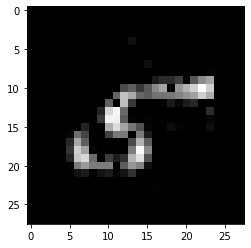

In [23]:
# Pick a few outputs and display them
import matplotlib.pyplot as plt
import random
idx = random.randint(0, 20)
out = outputs[idx, :].cpu().detach().numpy().reshape(28, 28) # Reshaping
plt.imshow(out, cmap="gray")

